In [ ]:
!wget http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz



--2022-04-21 12:15:18--  http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48002242 (46M) [application/x-gzip]
Saving to: ‘MovieSummaries.tar.gz’

MovieSummaries.tar. 100%[===================>]  45.78M  3.74MB/s    in 13s     

2022-04-21 12:15:31 (3.58 MB/s) - ‘MovieSummaries.tar.gz’ saved [48002242/48002242]



In [ ]:
!tar -xf MovieSummaries.tar.gz

In [ ]:
%cd MovieSummaries/

/content/MovieSummaries/MovieSummaries


In [ ]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
pd.set_option('display.max_colwidth', 300)


In [ ]:
%cd MovieSummaries/

[Errno 2] No such file or directory: 'MovieSummaries/'
/content/MovieSummaries/MovieSummaries


In [ ]:
meta = pd.read_csv("movie.metadata.tsv", sep = '\t', header = None)
meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [ ]:
meta.columns = ["movie_id",1,"movie_name",3,4,5,6,7,"genre"]
meta.head()

,movie_id,1,movie_name,3,4,5,6,7,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [ ]:
plots=[]
with open("plot_summaries.txt",'r') as f:
  reader=csv.reader(f,dialect='excel-tab')
  for row in tqdm(reader):
    plots.append(row)

42303it [00:02, 15329.09it/s]


In [ ]:

movie_id=[]
plot=[]

for i in tqdm(plots):
  movie_id.append(i[0])
  plot.append(i[1])

movies=pd.DataFrame({'movie_id':movie_id,'plot':plot})

100%|██████████| 42303/42303 [00:00<00:00, 585608.10it/s]


In [ ]:
movies.head()

,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo..."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r..."


In [ ]:


meta['movie_id']=meta['movie_id'].astype(str)
movies=pd.merge(movies,meta[['movie_id','movie_name','genre']],on='movie_id')
movies.head()


,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}"


In [ ]:
genres=[]
for i in movies['genre']:
  genres.append(list(json.loads(i).values())) 
movies['genre_new'] = genres

In [ ]:
movies_new = movies[~(movies['genre_new'].str.len() == 0)]

In [ ]:
movies_new.shape, movies.shape


((41793, 5), (42204, 5))

In [ ]:
movies.head()

,movie_id,plot,movie_name,genre,genre_new
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}","[Drama, World cinema]"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}","[Action/Adventure, Science Fiction, Action, Drama]"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}","[Musical, Action, Drama, Bollywood]"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}","[Screwball comedy, Comedy]"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}","[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]"


In [ ]:
all_genres = sum(genres,[])
len(set(all_genres))

363

In [ ]:
all_genres = nltk.FreqDist(all_genres) 
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
all_genres_df.head()

,Genre,Count
0,Drama,19134
1,World cinema,5153
2,Action/Adventure,3553
3,Science Fiction,2339
4,Action,5868


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

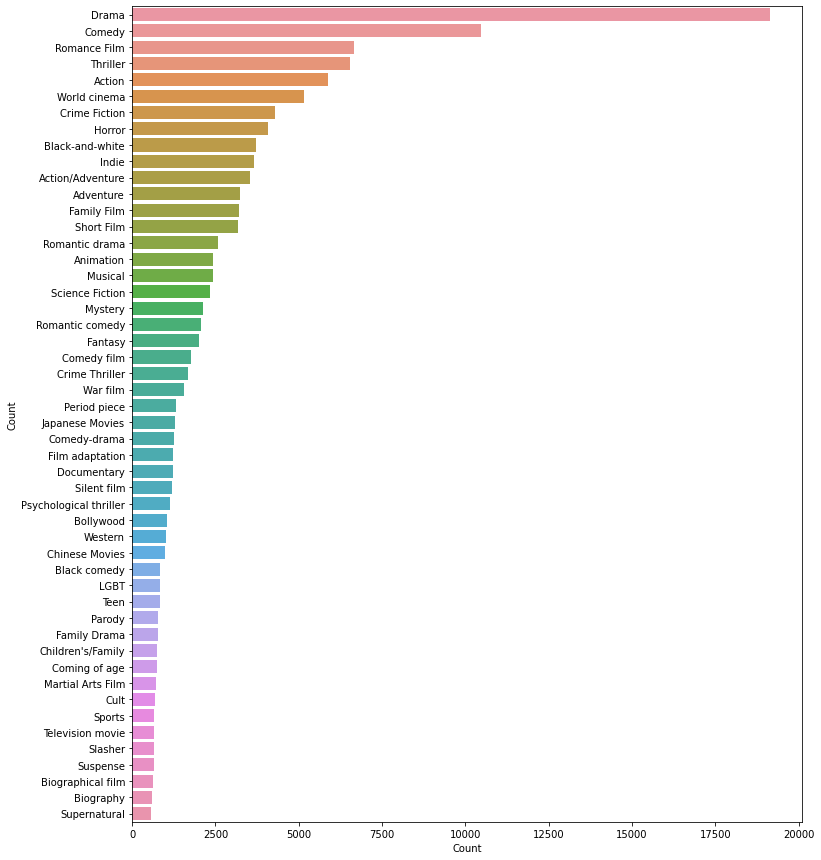

In [ ]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
from google.colab import files
plt.savefig("genre_freq.png")
files.download("genre_freq.png") 
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

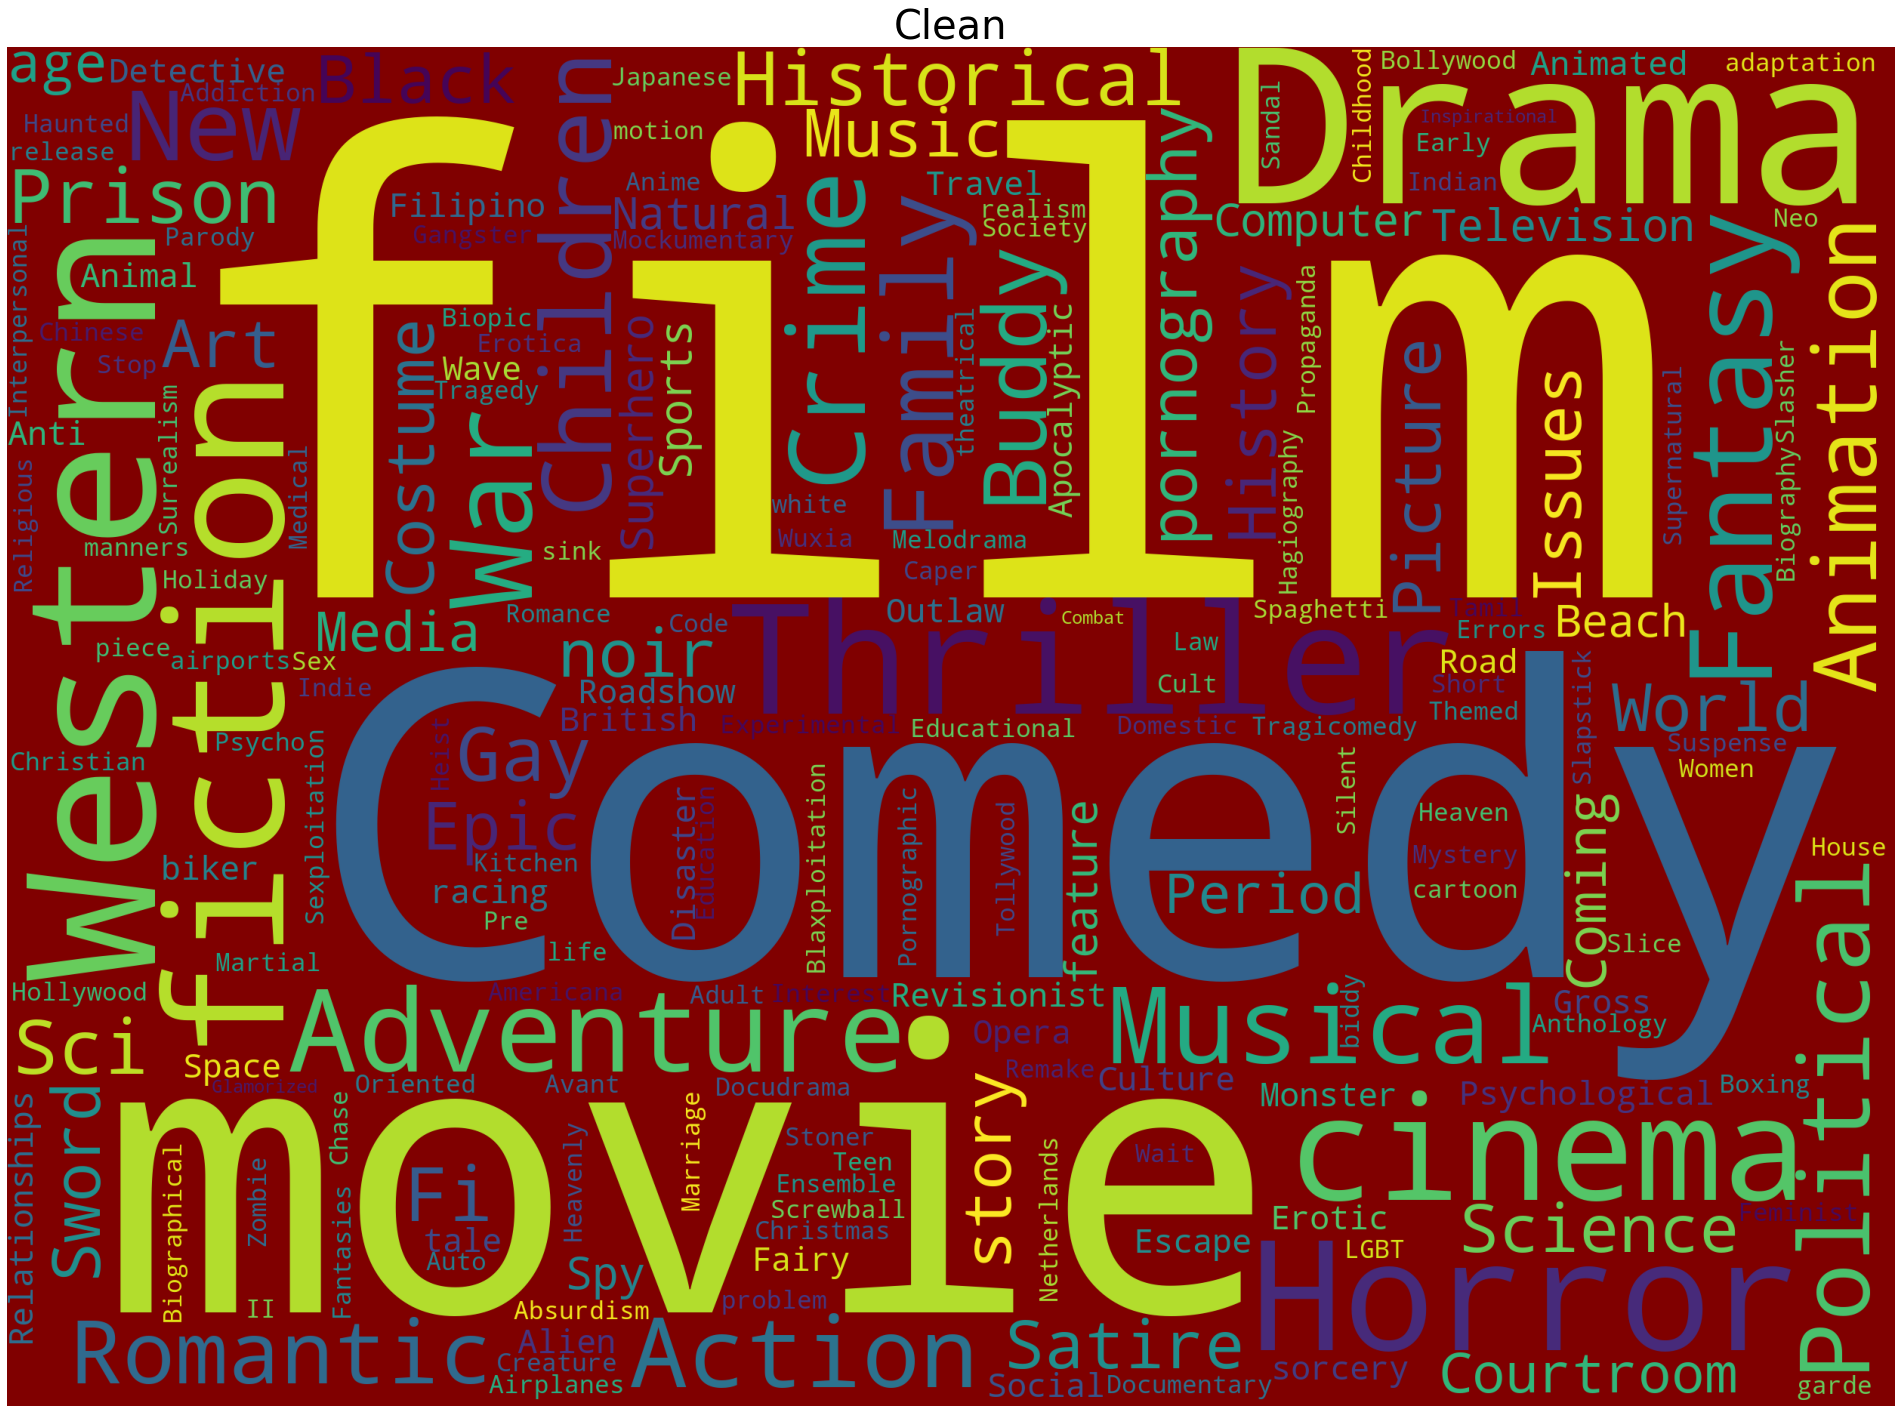

In [ ]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))

genres_cloud = WordCloud(
                          
                          background_color='maroon',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(all_genres_df['Genre']))
plt.axis('off')
plt.title("Clean",fontsize=40)

plt.imshow(genres_cloud)
plt.savefig("genre_wordcloud.png")
files.download("genre_wordcloud.png") 

In [ ]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [ ]:
movies_new['clean_plot']=movies_new['plot'].apply(lambda x:clean_text(x))
movies_new.head()

,movie_id,plot,movie_name,genre,genre_new,clean_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}","[Drama, World cinema]",shlykov a hard working taxi driver and lyosha a saxophonist develop a bizarre love hate relationship and despite their prejudices realize they arent so different after all
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}","[Action/Adventure, Science Fiction, Action, Drama]",the nation of panem consists of a wealthy capitol and twelve poorer districts as punishment for a past rebellion each district must provide a boy and girl between the ages of and selected by lottery for the annual hunger games the tributes must fight to the death in an arena the sole survivor is...
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}","[Musical, Action, Drama, Bollywood]",poovalli induchoodan is sentenced for six years prison life for murdering his classmate induchoodan the only son of justice maranchery karunakara menon was framed in the case by manapally madhavan nambiar and his crony dysp sankaranarayanan to take revenge on idealist judge menon who had earlier...
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}","[Screwball comedy, Comedy]",the lemon drop kid a new york city swindler is illegally touting horses at a florida racetrack after several successful hustles the kid comes across a beautiful but gullible woman intending to bet a lot of money the kid convinces her to switch her bet employing a prefabricated con unfortunately ...
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}","[Crime Fiction, Drama, Docudrama, World cinema, Courtroom Drama]",seventh day adventist church pastor michael chamberlain his wife lindy their two sons and their nine week old daughter azaria are on a camping holiday in the outback with the baby sleeping in their tent the family is enjoying a barbecue with their fellow campers when a cry is heard lindy returns...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

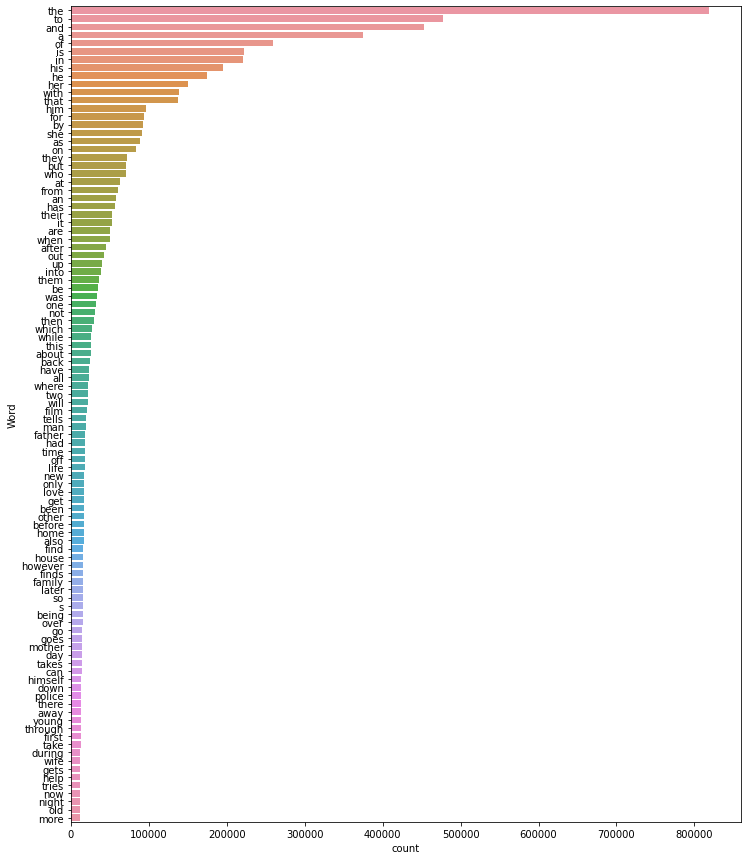

In [ ]:

def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.savefig("word_freq.png")
  files.download("word_freq.png") 
  plt.show()
  
# print 100 most frequent words 
freq_words(movies_new['clean_plot'], 100)

In [ ]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
pd.set_option('mode.chained_assignment', None)
# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies_new['clean_plot'] = movies_new['clean_plot'].apply(lambda x: remove_stopwords(x))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

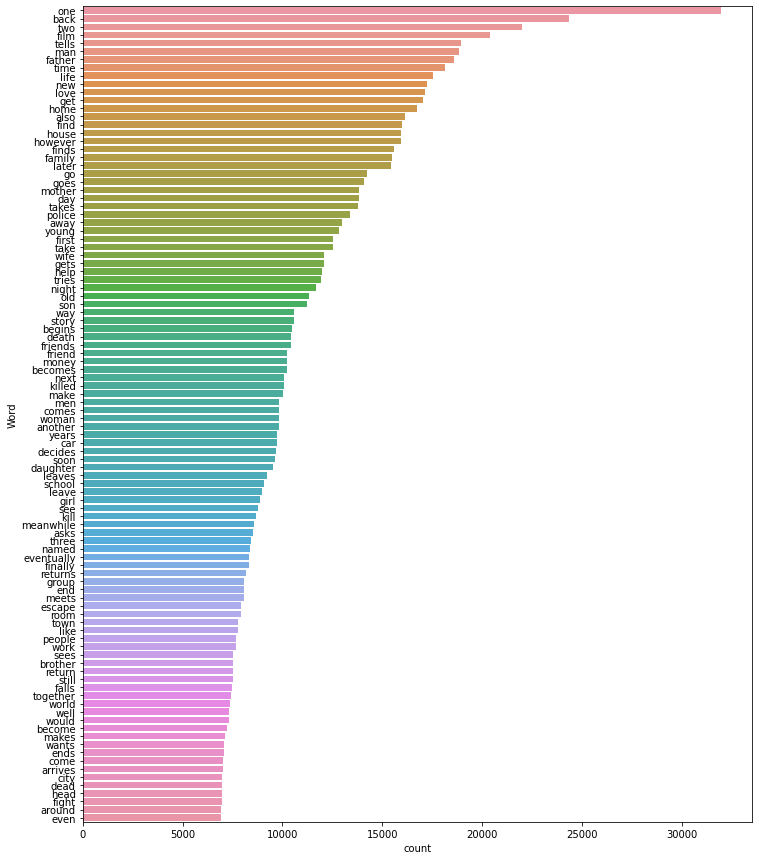

In [ ]:
freq_words(movies_new['clean_plot'], 100)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

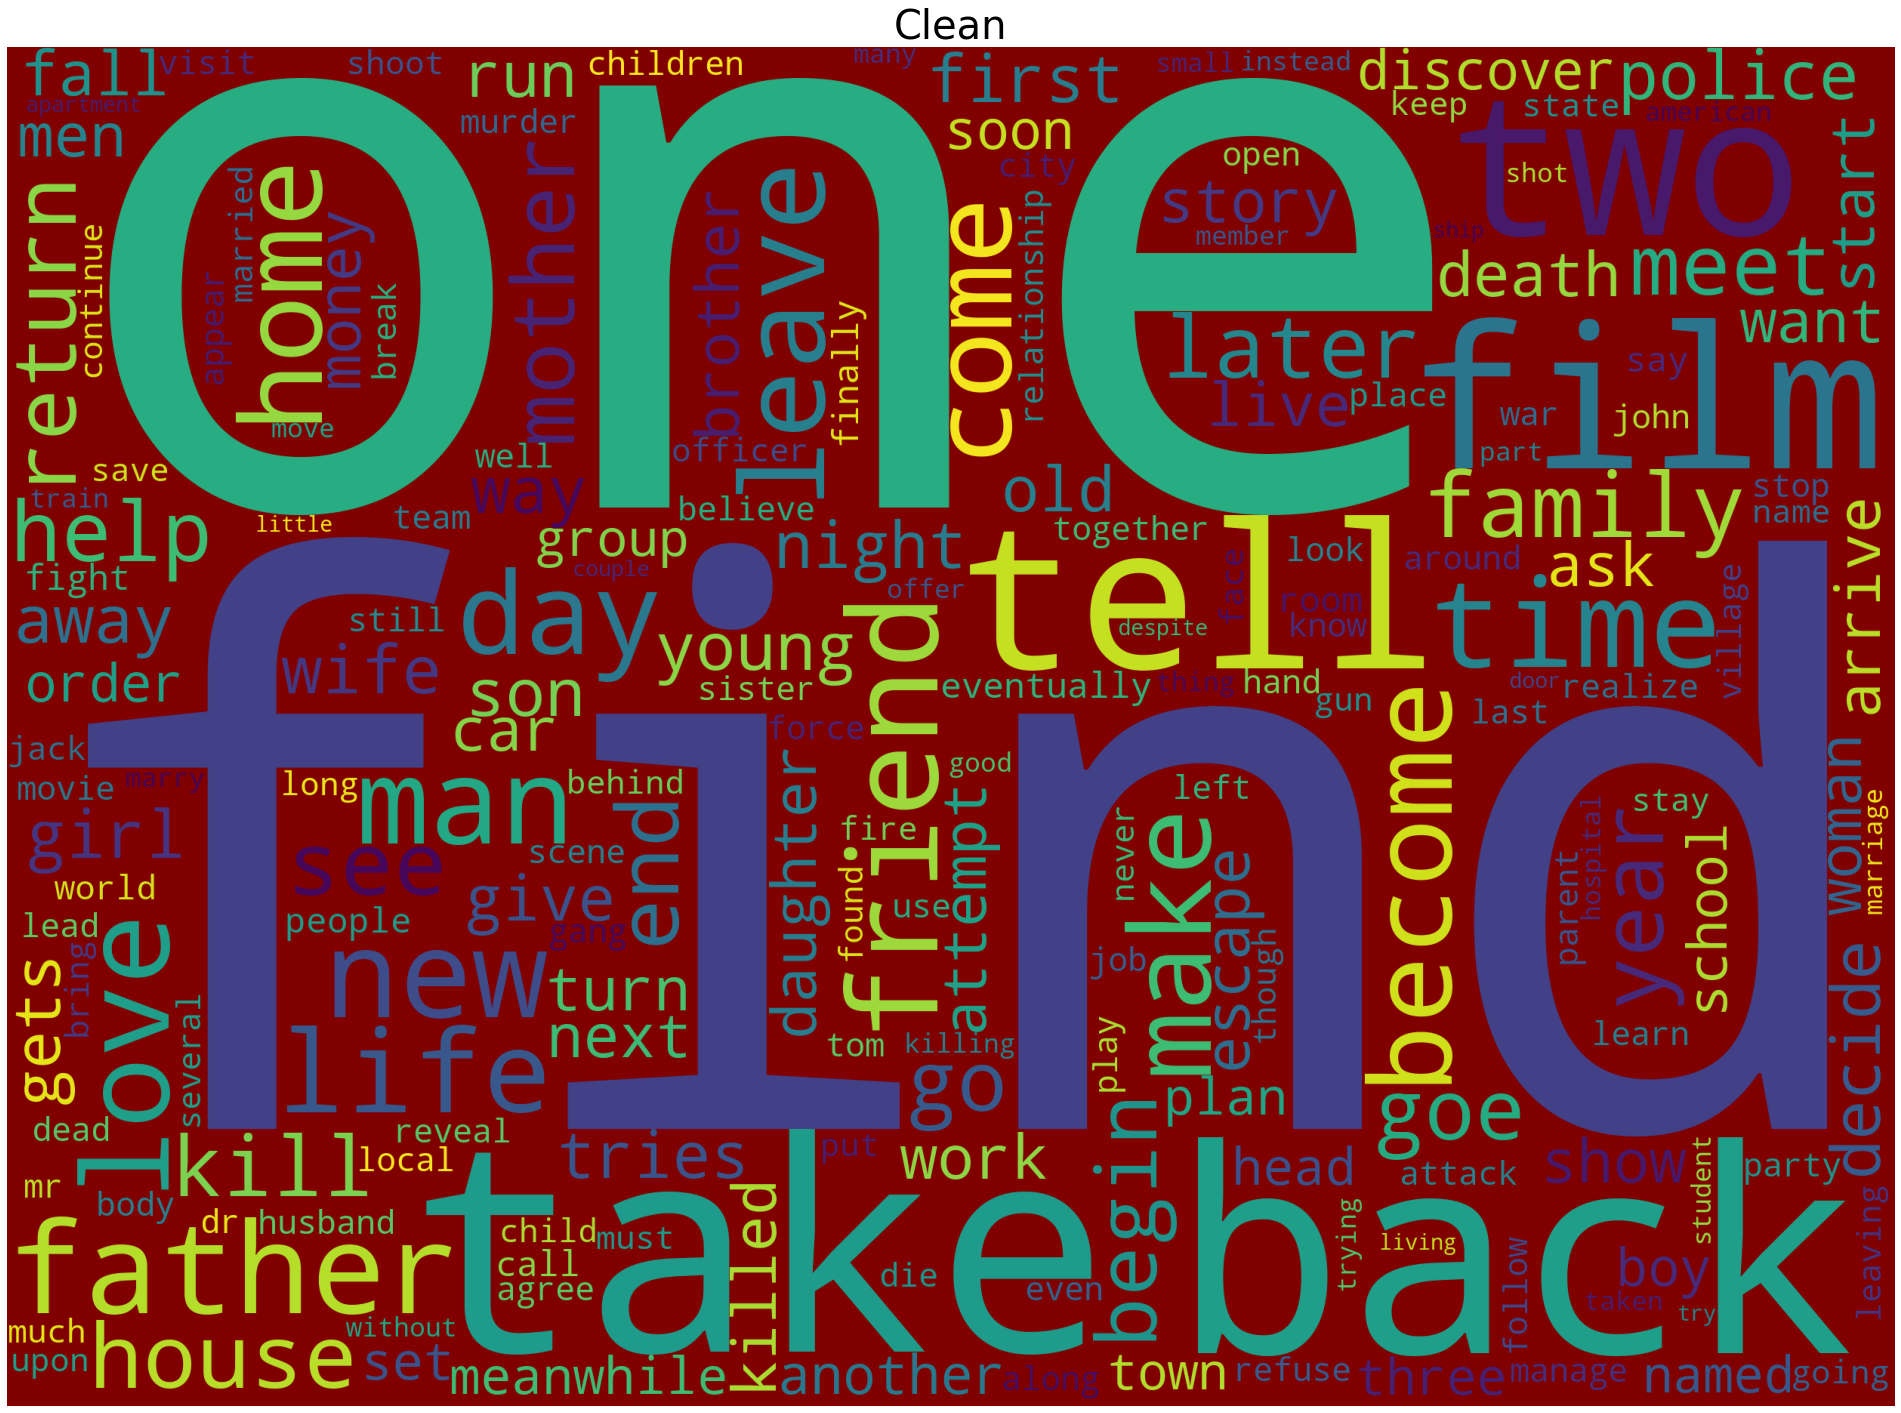

In [ ]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))
# clean

cloud_toxic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='maroon',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(movies_new['clean_plot']))
plt.axis('off')
plt.title("Clean",fontsize=40)
plt.imshow(cloud_toxic)
plt.savefig("word_wordcloud.png")
files.download("word_wordcloud.png") 

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
porter=PorterStemmer()
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)


In [ ]:
movies_new['stem_plot'] = movies_new['clean_plot'].apply(lambda x: stemSentence(x))

In [ ]:
movies_new.head()

,movie_id,plot,movie_name,genre,genre_new,clean_plot,stem_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}","[Drama, World cinema]",shlykov hard working taxi driver lyosha saxophonist develop bizarre love hate relationship despite prejudices realize arent different,shlykov hard work taxi driver lyosha saxophonist develop bizarr love hate relationship despit prejudic realiz arent differ
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}","[Action/Adventure, Science Fiction, Action, Drama]",nation panem consists wealthy capitol twelve poorer districts punishment past rebellion district must provide boy girl ages selected lottery annual hunger games tributes must fight death arena sole survivor rewarded fame wealth first reaping year old primrose everdeen chosen district older siste...,nation panem consist wealthi capitol twelv poorer district punish past rebellion district must provid boy girl age select lotteri annual hunger game tribut must fight death arena sole survivor reward fame wealth first reap year old primros everdeen chosen district older sister katniss volunt tak...
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}","[Musical, Action, Drama, Bollywood]",poovalli induchoodan sentenced six years prison life murdering classmate induchoodan son justice maranchery karunakara menon framed case manapally madhavan nambiar crony dysp sankaranarayanan take revenge idealist judge menon earlier given jail sentence manapally corruption case induchoodan achi...,pooval induchoodan sentenc six year prison life murder classmat induchoodan son justic marancheri karunakara menon frame case manap madhavan nambiar croni dysp sankaranarayanan take reveng idealist judg menon earlier given jail sentenc manap corrupt case induchoodan achiev top rank indian civil ...
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}","[Screwball comedy, Comedy]",lemon drop kid new york city swindler illegally touting horses florida racetrack several successful hustles kid comes across beautiful gullible woman intending bet lot money kid convinces switch bet employing prefabricated con unfortunately kid woman belongs notorious gangster moose moran money ...,lemon drop kid new york citi swindler illeg tout hors florida racetrack sever success hustl kid come across beauti gullibl woman intend bet lot money kid convinc switch bet employ prefabr con unfortun kid woman belong notori gangster moos moran money kid choic finish dead last furiou moran deman...
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. W

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['genre_new'])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import jaccard_score

In [ ]:
xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_plot'], y, test_size=0.2, random_state=9)


In [ ]:
def classification(vectorizer,classifier):
  if(vectorizer=='tfidf'):
    vect=TfidfVectorizer(max_df=0.8,max_features=1000)
  else:
    vect=CountVectorizer(max_df=0.8,max_features=1000)
  xtrain_tfidf = vect.fit_transform(xtrain)
  xval_tfidf = vect.transform(xval)
  lr=LogisticRegression()
  if(classifier=='logisticregression'):
    lr = LogisticRegression()
  elif(classifier=='multinomialnb'):
    lr=MultinomialNB()
  elif(classifier=='decisiontree'):
    lr=DecisionTreeClassifier()
  elif(classifier=='sgd'):
    lr=SGDClassifier()
  clf = OneVsRestClassifier(lr)
  clf.fit(xtrain_tfidf, ytrain)
  y_pred = clf.predict(xval_tfidf)
  pred=clf.predict(xtrain_tfidf)
  y_pred_prob = clf.predict(xval_tfidf)
  f1score=f1_score(yval, y_pred, average="micro")
  t = 0.3 # threshold value
  y_pred_new = (y_pred_prob >= t).astype(int)
  f1score_threshold=f1_score(yval, y_pred_new, average="micro")
  precision=precision_score(yval,y_pred_new,average='micro')
  recall=recall_score(yval, y_pred_new,average='micro')
  acc=accuracy_score(ytrain,pred)*1000
  print()
  print("Using "+vectorizer+" and "+ classifier)
  print()
  print("Precision: "+str(precision))
  print()
  print("Recall: "+str(recall))
  print()
  print("F1-score: "+str(f1score_threshold))
  print()
  # print("Hamming Loss: "+str(hamming_loss(yval,y_pred_new)))
 
  print()
  

In [ ]:
classification("tfidf","logisticregression")

/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 48 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 182 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 214 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 245 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])



Using tfidf and logisticregression

Precision: 0.6450817835536634

Recall: 0.1901459612971402

F1-score: 0.29371556825137723




In [ ]:
classification("countvectorizer","logisticregression")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Using countvectorizer and logisticregression

Precision: 0.45410976890756305

Recall: 0.22841952314906544

F1-score: 0.3039504328338533




In [ ]:
classification("tfidf","multinomialnb")
classification("countvectorizer","multinomialnb")

/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 48 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 182 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 214 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 245 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])



Using tfidf and multinomialnb

Precision: 0.6678520625889047

Recall: 0.0930255597384585

F1-score: 0.16330434782608697




/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 48 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 182 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 214 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 245 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])



Using countvectorizer and multinomialnb

Precision: 0.17393846611809233

Recall: 0.5402879598441318

F1-score: 0.2631570481888953




In [ ]:
classification("tfidf","sgd")
classification("countvectorizer","sgd")

/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 48 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 182 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 214 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 245 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])



Using tfidf and sgd

Precision: 0.6898871957253117

Recall: 0.11511789181692095

F1-score: 0.1973114475732277




/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 48 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 182 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 214 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 245 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])



Using countvectorizer and sgd

Precision: 0.4083500649580725

Recall: 0.2283534773132554

F1-score: 0.29290918332768556




In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=1000)
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)
lr = LogisticRegression()
clfm = OneVsRestClassifier(lr)
clfm.fit(xtrain_tfidf, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 48 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 182 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 214 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])
/usr/local/lib/python3.7/dist-packages/sklearn/multiclass.py:80: UserWarning: Label not 245 is present in all training examples.
  "Label %s is present in all training examples." % str(classes[c])


OneVsRestClassifier(estimator=LogisticRegression())

In [ ]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clfm.predict(q_vec)
    
    return multilabel_binarizer.inverse_transform(q_pred)

## **Testing for the movie Notebook which is a romantic film**

In [ ]:
infer_tags("n 1940s South Carolina, mill worker Noah Calhoun (Ryan Gosling) and rich girl Allie (Rachel McAdams) are desperately in love. But her parents don't approve. When Noah goes off to serve in World War II, it seems to mark the end of their love affair. In the interim, Allie becomes involved with another man (James Marsden). But when Noah returns to their small town years later, on the cusp of Allie's marriage, it soon becomes clear that their romance is anything but over.")

[('Drama', 'Romance Film', 'Romantic drama')]


## **Testing for the movie Evil Dead which is a horror film**

In [ ]:
infer_tags(" The people start turning into evil deadites, and the others soon learn from the tape that the only way to kill a person who is turned into a deadite is by total body dismemberment. People are dying left and right; one girl early in the film looses control and runs off into the woods, only to be raped by the trees.")

[('Horror',)]

## **Testing for the movie Batman begins which is a action film**

In [ ]:
infer_tags(" Summaries After training with his mentor, Batman begins his fight to free crime-ridden Gotham City from corruption. When his parents are killed, billionaire playboy Bruce Wayne relocates to Asia, where he is mentored by Henri Ducard and Ra's Al Ghul in how to fight evil.")

[('Action', 'Action/Adventure', 'Martial Arts Film')]

## **Testing for the movie Eternals which is a science fiction film**

In [ ]:
infer_tags(" The Eternals, a race of immortal beings with superhuman powers who have secretly lived on Earth for thousands of years, reunite to battle the evil Deviants.")

[('Fantasy', 'Science Fiction')]

In [ ]:
infer_tags(" A legendary rivalry reemerges when Jerry moves into New York City's finest hotel on the eve of the wedding of the century, forcing the desperate event planner to hire Tom to get rid of him. As mayhem ensues, the escalating cat-and-mouse battle soon threatens to destroy her career, the wedding, and possibly the hotel itself.")

[('Comedy',)]

In [ ]:
infer_tags("Two young people, Venkatesh and Nandini, get embroiled in a murder case when the strict principal is killed after he humiliates Nandini. A routine tale, the story begins with Venkata (Yash) a young student who has few issues in life. This takes a turn when he sees Nandini (Radhika) and falls for her.")

[('Drama',)]